In [1]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import netCDF4 as nc
import bisect
from scipy.stats import gaussian_kde
from scipy.stats import lognorm, norm

In [2]:
def hours_since_datetime(current_datetime,target_datetime):
    time_difference = current_datetime - target_datetime
    hours_difference = time_difference.total_seconds() / 3600
    return hours_difference

#### Load ERA5 Wind data 

In [3]:
wind_data = nc.Dataset("weather_permian.nc")
u10 = wind_data.variables["u10"][:]
v10 = wind_data.variables["v10"][:]
ws = (u10**2 + v10**2)**0.5
wind_data.close()

In [4]:
wind_speed = ws.copy()
wind_speed = list(wind_speed.flatten())

#### Load events 

In [5]:
events = pd.read_csv("events_with_uncertianty_case_study_1.csv")

In [6]:
events.head(2)

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation,duration_lower,duration_upper,rate_lower,rate_upper
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031431,False,0.0,0.0,1.101404,1.101404
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False,0.0,0.0,0.724935,0.724935


In [7]:
durations = list(events["duration"])

#### Load component-scale leak rate data 

In [8]:
leak_rates = pd.read_csv("sample_leak_rate.csv")

In [9]:
leak_rates.head(2)

,gpersec
0,0.003452
1,0.016511


In [10]:
leaks = list(leak_rates["gpersec"])
leaks_dist = []
for le in leaks: 
    if le == 0: 
        leaks_dist.append(0.0001)
    else: 
        leaks_dist.append(le)

#### Components count distribution

In [12]:
# component distribution 
mean = 2720  # Centered within the range of 1 and 5440
std_dev = 800  # Adjust for desired spread

# Generate random samples and filter to the desired range
num_comps = []
for _ in range(10000):  # Generate 100 samples as an example
    sample = np.random.normal(mean, std_dev)
    if 1 <= sample <= 5440:
        num_comps.append(sample)

# Convert to integers if you only want whole numbers
num_comps  = [int(x) for x in num_comps]

#### Fit the duration and rate distribution 

In [13]:
duration_log_normal = lognorm.fit(durations, floc=0)

In [14]:
duration_log_normal # mean and std of fitted distribution 

(2.4586123561386564, 0, 2.278538381231889)

In [15]:
duration_distribution = lognorm.rvs(*duration_log_normal, size=10000)

In [16]:
leaks_log_normal = lognorm.fit(leaks_dist, floc=0)

In [17]:
leaks_log_normal # mean and std of fitted distribution 

(3.268163402948174, 0, 0.0023221811999882417)

In [18]:
leak_distribution = list(lognorm.rvs(*leaks_log_normal, size=10000))

#### plot the input data distribution

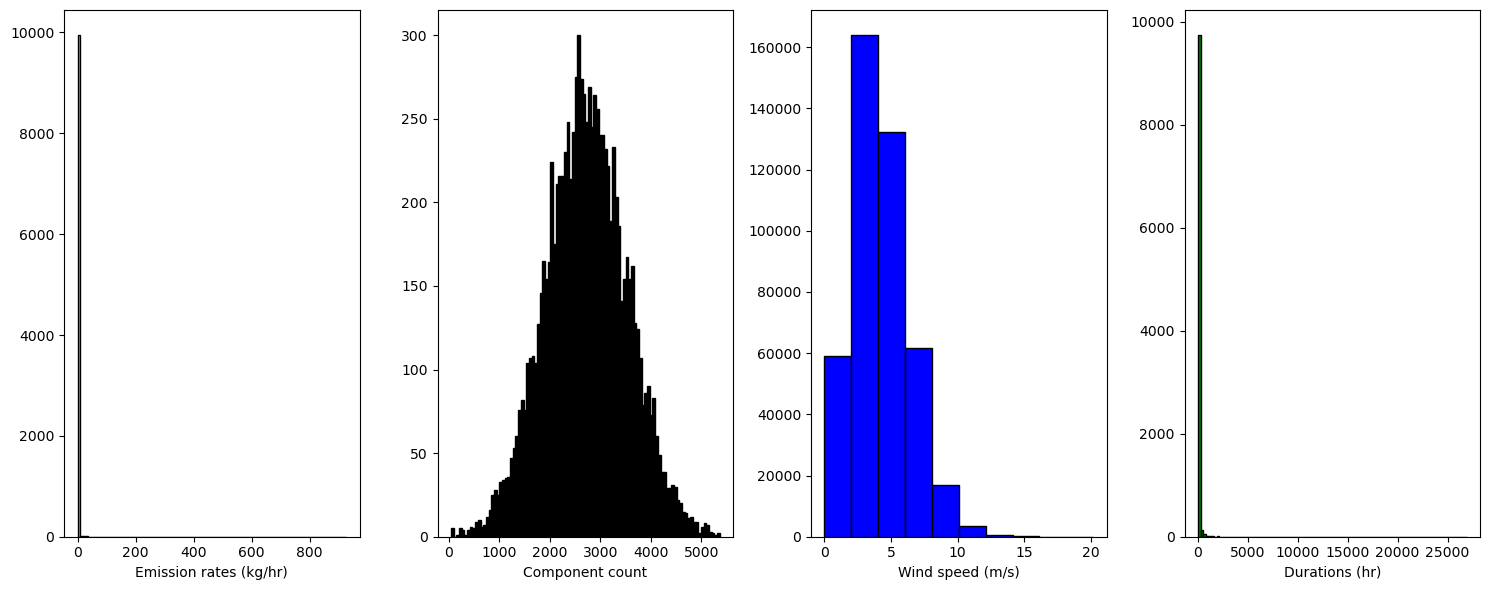

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

# Plotting on each subplot
axs[0].hist(leak_distribution, bins=100, color='orange', edgecolor='black')
axs[0].set_xlabel("Emission rates (kg/hr)")

axs[1].hist(num_comps, bins = 100, color = 'black', edgecolor ='black')
axs[1].set_xlabel("Component count")

axs[2].hist(wind_speed, bins=10, color='blue', edgecolor='black')
axs[2].set_xlabel("Wind speed (m/s)")

axs[3].hist(duration_distribution , bins=100, color='green', edgecolor='black')
axs[3].set_xlabel("Durations (hr)")

# Adjust layout
plt.tight_layout()
plt.show()

#### Simulate emissions from unresolved events  
Based on timestamps of our simulated emission events, our reconciliation period is 4 months from 2024-01-01 to 2024-04-31

In [20]:
def find_closest_after(numbers, target):
    # Sort the numbers first
    sorted_numbers = sorted(numbers)
    
    # Use bisect to find the insertion point for the target
    index = bisect.bisect_right(sorted_numbers, target)

    # Check if there is a number greater than the target
    if index < len(sorted_numbers):
        return sorted_numbers[index]  # Return the closest number greater than the target
    else:
        return None  # Return None if there are no valid numbers

In [21]:
def hours_since_datetime(current_datetime,target_datetime):
    time_difference = current_datetime - target_datetime
    hours_difference = time_difference.total_seconds() / 3600
    return hours_difference

In [22]:
Events_Times = [] 
init_datetime = datetime(2024,1,1,0,0,0)
for idx,row in events.iterrows():
    st = datetime.strptime(row.start_time,'%Y-%m-%d %H:%M:%S')
    et = datetime.strptime(row.end_time,'%Y-%m-%d %H:%M:%S')
    ct = st 
    while ct <= et:
        timestep = hours_since_datetime(ct,init_datetime)
        Events_Times.append(timestep)
        ct += timedelta(hours=1)

In [23]:
mc = 0
MC = 10000
Unmeausred_Emissions = [] 
Unmeasured_rates = [] 
Sampled_durations = []  
while mc < MC:
    E_miss = 0 
    D_miss = [] 
    Q_miss = []
    sim_start_time = []
    sim_end_time = [] 
    target_datetime = datetime(2024,5,1,0,0,0)
    current_datetime = datetime(2024,1,1,0,0,0)
    init_datetime = current_datetime
    while current_datetime <= target_datetime: 
        
        Q_sample = random.sample(leak_distribution,1)[0]
        Q_sample = Q_sample * random.sample(num_comps,1)[0]
        hour_since_start_time = hours_since_datetime(init_datetime,current_datetime)

        # get random u (wind speed) - wind speed sample from ERA5 dataset of Permian basin 
        # since out ficticious site locates at Permian basin 
        u = np.random.choice(wind_speed, size = 1)
        detection_label = False 
        
        # sampled emissions is not below MDL of flyover 
        if not detection_label and hour_since_start_time not in Events_Times: 
            # we assume passes of flyover survey is always 3 times 
            N = 3
            detection_label = False 
            for n in range(N): 
                # POD equation is from 
                # Conrad, B. M., Tyner, D. R., & Johnson, M. R. (2023). 
                # https://doi.org/10.1016/j.rse.2023.113499
                POD = 1 - (1+(((0.00771)/u**1.41)*Q_sample **1.87)**2)**-1.5
                rdp = random.random()
                if POD > rdp: 
                    # detection success 
                    detection_label = True
                    break


            N = 5 # number of qube sensors installed 
            for n in range(N): 
                # normalize the rate with wind speed 
                normQ = Q_sample /u 
                # POD equation (Bell et al., 2023 - https://doi.org/10.1021/acs.est.2c09235)
                POD_cms = 1/(1 + np.exp(-0.309-1.047*normQ)) # -> 0.5
                rdp = random.random() # -> 0.6
                if POD_cms > rdp: 
                    # detection success 
                    detection_label = True
                    break
                    
        if not detection_label:
            sim_start_time.append(current_datetime)
            Q_miss.append(Q_sample)
            # sampled a duration 
            sampled_duration = random.sample(durations,1)[0]
            closest_number = find_closest_after(Events_Times,hour_since_start_time)
            if closest_number:
                max_time_cap = closest_number - hour_since_start_time
                sampled_duration = min(sampled_duration, max_time_cap)
            E_miss += Q_sample * sampled_duration
            # update time with sampled duration 
            current_datetime += timedelta(hours=sampled_duration)
            sim_end_time.append(current_datetime)
            D_miss.append(sampled_duration)
        else:
            # update time by adding 1 hour 
            current_datetime += timedelta(hours=1)

    Unmeausred_Emissions.append(E_miss)
    Unmeasured_rates.append(Q_miss)
    Sampled_durations.append(D_miss)
    mc += 1 

In [66]:
np.median(Unmeausred_Emissions), np.percentile(Unmeausred_Emissions,q=2.5), np.percentile(Unmeausred_Emissions,q=97.5)

(35.22616276838076, 2.809887180382818, 956.1277759344273)